In [ ]:
# Importación de librerías fundamentales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Importaciones para análisis de series de tiempo
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Configuraciones de visualización
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 7)

# --- Carga de Datos ---
# NOTA: Asegúrate de que la ruta a los archivos sea la correcta.
try:
    path_train = '../../Datos/df_train.parquet'
    path_test = '../../Datos/df_test.parquet'
    path_submission = '../../Datos/sample_submission.csv'
    
    #df_train = pd.read_csv(path_train)
    df_train = pd.read_parquet(path_train)
    #df_test = pd.read_csv(path_test)
    df_test = pd.read_parquet(path_test)
    sample_submission = pd.read_csv(path_submission)

except FileNotFoundError:
    print("Archivos no encontrados en la ruta '../../Datos/'.")
    print("Cargando desde los archivos subidos al entorno actual como alternativa.")


# --- Estandarización de Nombres de Columnas ---
# Se usan 'anio' y 'semana' para la fecha.
if 'year' in df_train.columns:
    df_train.rename(columns={'year': 'anio', 'weekofyear': 'semana'}, inplace=True)
if 'year' in df_test.columns:
    df_test.rename(columns={'year': 'anio', 'weekofyear': 'semana'}, inplace=True)

# Se usa 'dengue' como target. Si no existe, se renombra 'total_cases'.
if 'total_cases' in df_train.columns and 'dengue' not in df_train.columns:
    df_train.rename(columns={'total_cases': 'dengue'}, inplace=True)
    # Para el test set, el target puede no estar o ser dummy, pero se renombra por consistencia
    if 'total_cases' in df_test.columns:
        df_test.rename(columns={'total_cases': 'dengue'}, inplace=True)

# Define la variable objetivo a partir de este punto
TARGET_COL = 'dengue'


# --- Procesamiento de Fechas y Establecimiento del Índice ---
def set_datetime_index(df):
    df['fecha'] = pd.to_datetime(df['anio'].astype(str) + '-' + df['semana'].astype(str) + '-1', format='%Y-%W-%w')
    df = df.set_index('fecha')
    df = df.sort_index()
    return df

df_train = set_datetime_index(df_train)
df_test = set_datetime_index(df_test)

print("--- Columnas del DataFrame de Entrenamiento ---")
print(df_train.columns)
print(f"\nVariable objetivo establecida a: '{TARGET_COL}'")

--- Columnas del DataFrame de Entrenamiento ---
Index(['id', 'id_bar', 'anio', 'semana', 'ESTRATO', 'area_barrio', 'dengue',
       'concentraciones', 'vivienda', 'equipesado', 'sumideros', 'maquina',
       'lluvia_mean', 'lluvia_var', 'lluvia_max', 'lluvia_min',
       'temperatura_mean', 'temperatura_var', 'temperatura_max',
       'temperatura_min'],
      dtype='object')

Variable objetivo establecida a: 'dengue'


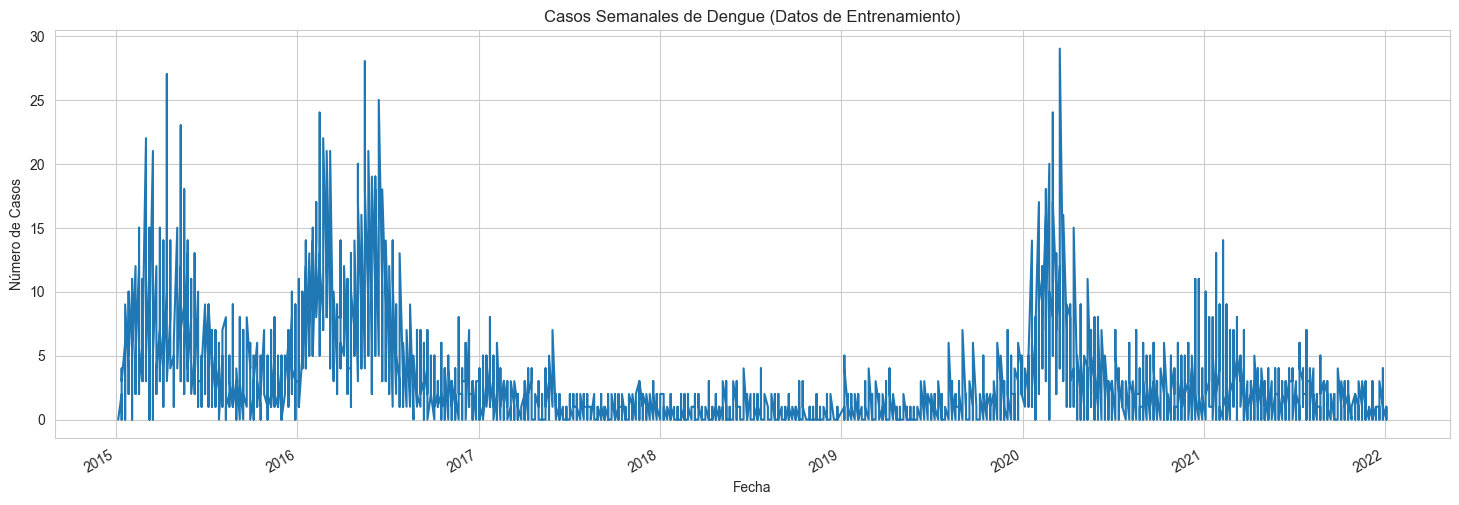

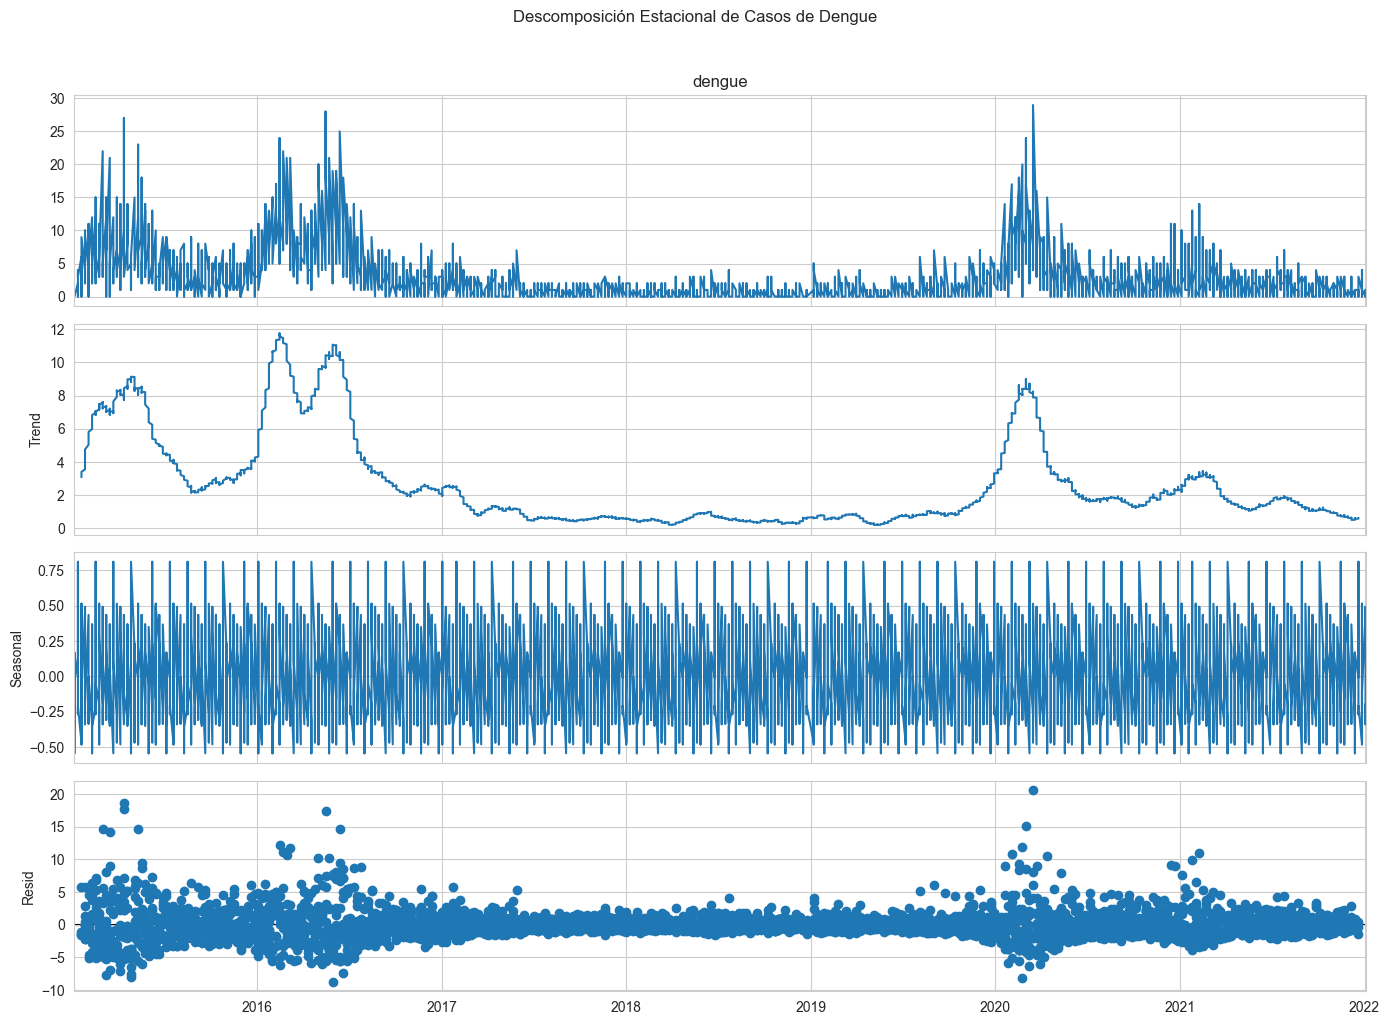

In [14]:
# Visualización de la serie de tiempo de casos de dengue
plt.figure(figsize=(18, 6))
df_train[TARGET_COL].plot()
plt.title('Casos Semanales de Dengue (Datos de Entrenamiento)')
plt.xlabel('Fecha')
plt.ylabel('Número de Casos')
plt.show()

# Descomposición Estacional
# Se interpola para manejar posibles valores faltantes antes de la descomposición
decomposition = seasonal_decompose(df_train[TARGET_COL].interpolate(), model='additive', period=52)
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.suptitle('Descomposición Estacional de Casos de Dengue', y=1.02)
plt.tight_layout()
plt.show()

In [15]:
# Importación de librerías para el modelado
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import optuna

# Verificar si hay una GPU disponible y definir el dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando dispositivo: {device}')

# --- Combinar, Codificar y Escalar ---

# 1. Combinar dataframes para un preprocesamiento consistente
train_index = df_train.index
test_index = df_test.index
all_data = pd.concat([df_train, df_test], axis=0)

# Llenar valores nulos
all_data.interpolate(method='linear', limit_direction='forward', inplace=True)
all_data.fillna(method='ffill', inplace=True)
all_data.fillna(method='bfill', inplace=True)

# 2. Codificación One-Hot para la columna 'estrato'
if 'ESTRATO' in all_data.columns:
    print("\nRealizando codificación One-Hot en la columna 'estrato'...")
    all_data = pd.get_dummies(all_data, columns=['ESTRATO'], prefix='ESTRATO', drop_first=True)
else:
    print("\nAdvertencia: La columna 'estrato' no se encontró. No se aplicará One-Hot Encoding.")


# 3. Definir columnas de features y target
# Se excluyen columnas de ID, la target y la columna 'lluvia_min'
excluded_cols = ['city', 'anio', 'semana', TARGET_COL, 'lluvia_min','lluvia_max','lluvia_var','temperatura_min','temperatura_var','temperatura_max']



feature_cols = [col for col in all_data.columns if col not in excluded_cols]

print(f"\nNúmero de features utilizadas: {len(feature_cols)}")
print(f"Columna excluida explícitamente: 'lluvia_min'")


# 4. Escalar características
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

df_train_processed = all_data.loc[train_index]
df_test_processed = all_data.loc[test_index]

feature_scaler.fit(df_train_processed[feature_cols])
target_scaler.fit(df_train_processed[[TARGET_COL]])

all_data_scaled = all_data.copy()
all_data_scaled[feature_cols] = feature_scaler.transform(all_data[feature_cols])
all_data_scaled[TARGET_COL] = target_scaler.transform(all_data[[TARGET_COL]])

df_train_scaled = all_data_scaled.loc[train_index]
df_test_scaled = all_data_scaled.loc[test_index]


# 5. Crear Secuencias
def create_sequences(features, target, seq_length):
    X, y = [], []
    for i in range(len(features) - seq_length):
        X.append(features.iloc[i:(i + seq_length)].values)
        y.append(target.iloc[i + seq_length])
    return np.array(X), np.array(y)

SEQUENCE_LENGTH = 12

X_train, y_train = create_sequences(df_train_scaled[feature_cols], df_train_scaled[TARGET_COL], SEQUENCE_LENGTH)
X_val, y_val = create_sequences(df_test_scaled[feature_cols], df_test_scaled[TARGET_COL], SEQUENCE_LENGTH)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

print(f"\nForma de X_train_tensor: {X_train_tensor.shape}")
print(f"Forma de X_val_tensor: {X_val_tensor.shape}")

Usando dispositivo: cuda

Realizando codificación One-Hot en la columna 'estrato'...

Número de features utilizadas: 12
Columna excluida explícitamente: 'lluvia_min'


C:\Users\usuario\AppData\Local\Temp\ipykernel_23616\3747835928.py:20: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  all_data.interpolate(method='linear', limit_direction='forward', inplace=True)
C:\Users\usuario\AppData\Local\Temp\ipykernel_23616\3747835928.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  all_data.fillna(method='ffill', inplace=True)
C:\Users\usuario\AppData\Local\Temp\ipykernel_23616\3747835928.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  all_data.fillna(method='bfill', inplace=True)



Forma de X_train_tensor: torch.Size([37488, 12, 12])
Forma de X_val_tensor: torch.Size([5288, 12, 12])


In [16]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_rate if num_layers > 1 else 0
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out

In [17]:
def objective(trial):
    params = {
        'hidden_size': trial.suggest_int('hidden_size', 32, 256),
        'num_layers': trial.suggest_int('num_layers', 1, 3),
        'dropout_rate': trial.suggest_float('dropout_rate', 0.1, 0.5),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64])
    }
    
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)

    input_size = X_train_tensor.shape[2]
    model = GRUModel(input_size, params['hidden_size'], params['num_layers'], 1, params['dropout_rate']).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
    
    epochs = 25
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

    model.eval()
    validation_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            validation_loss += loss.item()

    return validation_loss / len(val_loader)

# NOTA: n_trials=50 puede tardar. Para una prueba rápida, puedes reducirlo.
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("\n--- Optimización con Optuna Finalizada ---")
print(f"Mejor trial (loss): {study.best_trial.value}")
best_hyperparams = study.best_params
print("Mejores Hiperparámetros:")
for key, value in best_hyperparams.items():
    print(f"  {key}: {value}")

[I 2025-06-17 23:17:15,948] A new study created in memory with name: no-name-80ad9ef1-dd02-4c41-8c2b-b2b149ec1f30
[I 2025-06-17 23:18:53,160] Trial 0 finished with value: 0.00903892086353153 and parameters: {'hidden_size': 220, 'num_layers': 1, 'dropout_rate': 0.24118111381317578, 'learning_rate': 0.0066219473006367095, 'batch_size': 16}. Best is trial 0 with value: 0.00903892086353153.
[I 2025-06-17 23:21:13,978] Trial 1 finished with value: 0.008550210622960689 and parameters: {'hidden_size': 135, 'num_layers': 3, 'dropout_rate': 0.4879200395607992, 'learning_rate': 0.0020121444927578207, 'batch_size': 16}. Best is trial 1 with value: 0.008550210622960689.
[I 2025-06-17 23:21:48,984] Trial 2 finished with value: 0.01035181793148618 and parameters: {'hidden_size': 237, 'num_layers': 2, 'dropout_rate': 0.4522180009921949, 'learning_rate': 0.0044189316548781, 'batch_size': 64}. Best is trial 1 with value: 0.008550210622960689.
[I 2025-06-17 23:22:13,520] Trial 3 finished with value: 0.0

KeyboardInterrupt: 

In [ ]:
# Unir todos los datos disponibles (procesados y escalados)
full_data_scaled = pd.concat([df_train_scaled, df_test_scaled])
X_full, y_full = create_sequences(full_data_scaled[feature_cols], full_data_scaled[TARGET_COL], SEQUENCE_LENGTH)
X_full_tensor = torch.tensor(X_full, dtype=torch.float32)
y_full_tensor = torch.tensor(y_full, dtype=torch.float32).unsqueeze(1)

full_dataset = TensorDataset(X_full_tensor, y_full_tensor)
full_loader = DataLoader(full_dataset, batch_size=best_hyperparams['batch_size'], shuffle=True)

# Instanciar el modelo final con los mejores hiperparámetros
final_model = GRUModel(
    input_size=X_full_tensor.shape[2],
    hidden_size=best_hyperparams['hidden_size'],
    num_layers=best_hyperparams['num_layers'],
    output_size=1,
    dropout_rate=best_hyperparams['dropout_rate']
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(final_model.parameters(), lr=best_hyperparams['learning_rate'])

# Bucle de entrenamiento final
epochs = 100
print("\n--- Iniciando Entrenamiento del Modelo Final ---")
for epoch in range(epochs):
    final_model.train()
    epoch_loss = 0
    for X_batch, y_batch in full_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = final_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(full_loader):.6f}')
print("--- Entrenamiento Finalizado ---")

In [ ]:
num_forecast_steps = len(sample_submission)
print(f"Número de semanas a pronosticar: {num_forecast_steps}")

last_sequence_features = full_data_scaled[feature_cols].values[-SEQUENCE_LENGTH:]

predictions_scaled = []
final_model.eval()
current_sequence = torch.tensor(last_sequence_features, dtype=torch.float32).unsqueeze(0).to(device)

future_exog_features = df_test_scaled[feature_cols].iloc[-num_forecast_steps:]

with torch.no_grad():
    for i in range(num_forecast_steps):
        next_step_pred_scaled = final_model(current_sequence)
        predictions_scaled.append(next_step_pred_scaled.item())
        
        next_features_exog = future_exog_features.iloc[i].values
        
        new_sequence_features = np.vstack([
            current_sequence.cpu().numpy().squeeze(0)[1:],
            next_features_exog
        ])
        
        current_sequence = torch.tensor(new_sequence_features, dtype=torch.float32).unsqueeze(0).to(device)

# Des-escalar las predicciones para obtener el número real de casos
predictions_descaled = target_scaler.inverse_transform(np.array(predictions_scaled).reshape(-1, 1))

# Redondear a entero, ya que los casos de dengue no pueden ser fraccionarios
final_predictions = np.round(predictions_descaled).astype(int).flatten()

print("\n--- Primeras 10 predicciones (casos de dengue) ---")
print(final_predictions[:10])

In [ ]:
# Crear el DataFrame de submission
# Aunque el target del modelo es 'dengue', el archivo de submission requiere la columna 'total_cases'
submission_df = sample_submission.copy()
submission_df['dengue'] = final_predictions

# Verificar el formato
print("\n--- Formato del Archivo de Submission ---")
print(submission_df.head())

# Guardar el archivo final
submission_df.to_csv('submission_Gemini_GRU.csv', index=False)

print("\nArchivo 'submission.csv' generado exitosamente.")